In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
airplanes_df = pd.read_csv('../../data/Clean_Dataset.csv') # read our CSV file
airplanes1_df = airplanes_df#.drop(['Unnamed: 0'], axis=1) #drops the first  column (id)
airplanes_train, airplanes_test = train_test_split(airplanes1_df, test_size=0.2, random_state=4) # on divise les données en 2 sets
###
#airplane_train and _test sont de type <class 'pandas.core.frame.DataFrame'> (the last column is price)

In [9]:
class Node():
    
    def __init__(self, X, depth):
        self.name = ''
        self.X_parent = X
        self.left = None #noeud de gauche
        self.right = None #noeud de droite
        self.depth = depth
        self.column = None
        self.condition = None
        self.MSE = mean_squared_error([np.mean(self.X_parent['price'])]*len(self.X_parent['price']) , self.X_parent['price'])
    
    def separate_from_class(self,column, condition): # pour separateurs par classification
        X_gauche = self.X_parent[self.X_parent[column] == condition]
        X_droite = self.X_parent[self.X_parent[column] != condition]
        if (X_gauche.empty | X_droite.empty):
            #print("VIDE: ", column,"==", condition )
            return self.MSE
        
        size_G = len(X_gauche['price'])
        size_D = len(X_droite['price'])
        
        MSE_G = mean_squared_error([np.mean(X_gauche['price'])]*size_G , X_gauche['price'])
        MSE_D = mean_squared_error([np.mean(X_droite['price'])]*size_D , X_droite['price'])

        return ( MSE_G*size_G + MSE_D*size_D )/(size_G + size_D)
        
    def separate_from_int(self,column,condition): # pour separateurs par rapport a une valeur
        X_gauche = self.X_parent[self.X_parent[column] < float(condition)]
        X_droite = self.X_parent[self.X_parent[column] >= float(condition)]
        if (X_gauche.empty | X_droite.empty):
            #print("VIDE: ", column," < ", condition )
            return self.MSE
        
        size_G = len(X_gauche['price'])
        size_D = len(X_droite['price'])
        
        MSE_G = mean_squared_error([np.mean(X_gauche['price'])]*size_G , X_gauche['price'])
        MSE_D = mean_squared_error([np.mean(X_droite['price'])]*size_D , X_droite['price'])

        return ( MSE_G*size_G + MSE_D*size_D )/(size_G + size_D)
    
    def best_split(self):
        best_MSE = self.MSE
        best_cond = self.condition
        best_column = self.column
        for column in self.X_parent.select_dtypes(include=np.number).columns.drop(["Unnamed: 0","price"]).tolist():
            #print(column)
            for trait in np.sort(self.X_parent[column].unique())[1:]:
                MSE = self.separate_from_int(column,trait)
                if ( MSE < best_MSE):
                    best_MSE = MSE
                    best_cond = trait
                    best_column = column
                    
        for column in self.X_parent.select_dtypes(include=['object']).columns.drop(["flight"]).tolist() :
            for trait in np.sort(self.X_parent[column].unique()):
                MSE = self.separate_from_class(column,trait)
                if ( MSE < best_MSE):
                    best_MSE = MSE
                    best_cond = trait
                    best_column = column
        self.MSE = best_MSE
        self.condition = best_cond
        self.column = best_column
        
        if self.column in self.X_parent.select_dtypes(include=np.number).columns.drop(["Unnamed: 0","price"]).tolist():
            print(self.depth," : ",self.name,"\t MSE: ", MSE,"\t cond:", self.column,"<", self.condition )
        else :
            print(self.depth," : ",self.name,"\t MSE: ", MSE,"\t cond:", self.column,"==", self.condition )

In [35]:
class Tree():
    def __init__(self,X,max_depth):
        self.leaves = []
        self.root = Node(X,0)
        self.root.name += 'root '
        self.max_depth = max_depth
        
    def branch(self,noeud):
        noeud.best_split()
        if noeud.column in noeud.X_parent.select_dtypes(include=np.number).columns.drop(["Unnamed: 0","price"]).tolist():
            X_gauche = noeud.X_parent[noeud.X_parent[noeud.column] < float(noeud.condition)]
            X_droite = noeud.X_parent[noeud.X_parent[noeud.column] >= float(noeud.condition)]
        else :
            X_gauche = noeud.X_parent[noeud.X_parent[noeud.column] == noeud.condition]
            X_droite = noeud.X_parent[noeud.X_parent[noeud.column] != noeud.condition]
        if noeud.depth == self.max_depth:
            noeud.left = X_gauche
            noeud.right = X_droite
            self.leaves.append(X_gauche)
            self.leaves.append(X_droite)
            print(noeud.depth + 1," : ",noeud.name+'L',"\t MSE: ", mean_squared_error([np.mean(noeud.left['price'])]*len(noeud.left['price']) , noeud.left['price']),"\t leaf: ", np.mean(noeud.left['price']))
            print(noeud.depth + 1," : ",noeud.name+'R',"\t MSE: ", mean_squared_error([np.mean(noeud.right['price'])]*len(noeud.right['price']) , noeud.right['price']),"\t leaf: ", np.mean(noeud.right['price']))
        else :
            noeud.left = Node(X_gauche , noeud.depth + 1)
            noeud.right = Node(X_droite , noeud.depth + 1)
            noeud.left.name = noeud.name + 'L '
            noeud.right.name = noeud.name + 'R '
            self.branch(noeud.left)
            self.branch(noeud.right)
        return
    
    def grow(self):
        self.branch(self.root)
        
    def classify(self):
        return
    

In [36]:
arbre = Tree(airplanes_df,6)
arbre.grow()

0  :  root  	 MSE:  62037785.990201846 	 cond: class == Business
1  :  root L  	 MSE:  168201322.14790034 	 cond: duration < 4.58
2  :  root L L  	 MSE:  46654081.58247605 	 cond: duration < 2.08
3  :  root L L L  	 MSE:  12314165.6446174 	 cond: duration < 1.67
4  :  root L L L L  	 MSE:  6404598.255673037 	 cond: duration < 1.42
5  :  root L L L L L  	 MSE:  7370833.885236294 	 cond: source_city == Mumbai
6  :  root L L L L L L  	 MSE:  159183.35999999996 	 cond: days_left < 4
7  :  root L L L L L L L 	 MSE:  0.0 	 leaf:  19228.0
7  :  root L L L L L L R 	 MSE:  0.0 	 leaf:  17548.0
6  :  root L L L L L R  	 MSE:  4747804.332408511 	 cond: destination_city == Mumbai
7  :  root L L L L L R L 	 MSE:  0.0 	 leaf:  17738.0
7  :  root L L L L L R R 	 MSE:  1242649.5717770688 	 leaf:  12499.643835616438
5  :  root L L L L R  	 MSE:  2642324.3409225573 	 cond: source_city == Bangalore
6  :  root L L L L R L  	 MSE:  1744639.555555556 	 cond: days_left < 5
7  :  root L L L L R L L 	 MSE:  10

In [37]:
print(np.sort([int(np.mean(leaf['price'])) for leaf in arbre.leaves]))

[ 1579  1828  2138  2597  2805  2824  2875  2907  3084  3285  3445  3482
  3614  3632  3704  3815  3898  3906  3978  3979  4270  4364  4550  4579
  4718  4801  5003  5443  5608  5652  5654  6200  6219  6310  6631  6775
  6903  7225  7380  7441  7472  7720  8540  8833  8984  9128  9468 10977
 11105 11522 11884 12382 12499 12527 13396 13837 14276 14280 14466 15549
 16745 17548 17738 17738 17778 17843 18667 19228 19916 20233 20525 20886
 21297 21348 22140 22290 23020 23162 23386 23991 24318 25053 26045 26107
 26388 26685 27348 27432 27976 28003 29680 30630 31133 31150 33567 35667
 37280 38470 39778 41827 42186 43943 44016 46117 46251 48050 48399 50139
 51168 54540 55175 55301 55633 56172 59767 60529 61058 62781 63490 64353
 65678 66266 72145 72889 74103 79917 81359 81722]


In [38]:
print('if' , arbre.root.right.left.right.right.left.left.column,' < ou == ',arbre.root.right.left.right.right.left.left.condition ,'then left')

if days_left  < ou ==  11 then left


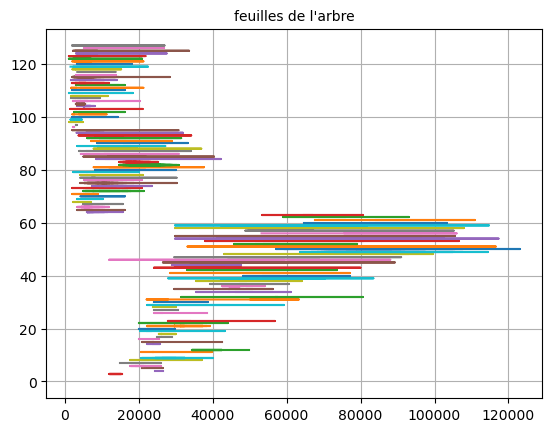

In [40]:
fig = plt.figure(1)	#identifies the figure 
plt.title("feuilles de l'arbre", fontsize='10')	#title
k = 0
for leaf in arbre.leaves:
    plt.plot(list(leaf['price']), [k]*len(list(leaf['price'])))	#plot the points
    k+=1
plt.grid()	#shows a grid under the plot
plt.show()